In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


C:\Users\benna435\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\benna435\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\benna435\AppData\Roaming\Python\Python312\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto

In [2]:
ticker = "AAPL"

data = yf.download(ticker, start="2000-01-01", auto_adjust=True)
prices = data["Close"].dropna()

prices.head(), prices.tail()


[*********************100%***********************]  1 of 1 completed


(Ticker          AAPL
 Date                
 2000-01-03  0.839281
 2000-01-04  0.768521
 2000-01-05  0.779767
 2000-01-06  0.712287
 2000-01-07  0.746027,
 Ticker            AAPL
 Date                  
 2025-11-11  275.250000
 2025-11-12  273.470001
 2025-11-13  272.950012
 2025-11-14  272.410004
 2025-11-17  266.929993)

In [3]:
WINDOW = 60    # 3 months
HORIZON = 60   # 1 quarter

def create_sequences(series, window=WINDOW, horizon=HORIZON):
    X, y = [], []
    series = np.array(series)

    for i in range(len(series) - window - horizon):
        window_data = series[i:i+window]
        future_price = series[i+window+horizon]
        current_price = series[i+window]

        target_return = future_price/current_price - 1
        
        X.append(window_data)
        y.append(target_return)
    
    return np.array(X), np.array(y)

X, y = create_sequences(prices.values)
X.shape, y.shape


((6389, 60, 1), (6389, 1))

In [25]:
X

array([[[  0.83928061],
        [  0.76852083],
        [  0.77976674],
        ...,
        [  1.03984618],
        [  1.04640627],
        [  1.04312682]],

       [[  0.76852083],
        [  0.77976674],
        [  0.71228695],
        ...,
        [  1.04640627],
        [  1.04312682],
        [  1.01922691]],

       [[  0.77976674],
        [  0.71228695],
        [  0.74602735],
        ...,
        [  1.04312682],
        [  1.01922691],
        [  0.94284385]],

       ...,

       [[194.85974121],
        [199.78936768],
        [199.99893188],
        ...,
        [231.3657074 ],
        [230.66639709],
        [230.3367157 ]],

       [[199.78936768],
        [199.99893188],
        [199.52990723],
        ...,
        [230.66639709],
        [230.3367157 ],
        [225.79110718]],

       [[199.99893188],
        [199.52990723],
        [200.42802429],
        ...,
        [230.3367157 ],
        [225.79110718],
        [224.68218994]]])

In [7]:
def normalize(X):
    return X / X[:, 0:1]

X_norm = normalize(X)
X_norm = X_norm.reshape(X_norm.shape[0], X_norm.shape[1], 1)   # LSTM format

X_norm.shape

(6389, 60, 1)

In [17]:
X_norm

array([[[1.        ],
        [0.91568997],
        [0.92908943],
        ...,
        [1.23897321],
        [1.24678953],
        [1.24288208]],

       [[1.        ],
        [1.01463318],
        [0.92682842],
        ...,
        [1.36158478],
        [1.35731756],
        [1.32621897]],

       [[1.        ],
        [0.91346157],
        [0.95673143],
        ...,
        [1.33774214],
        [1.30709206],
        [1.20913577]],

       ...,

       [[1.        ],
        [1.02529833],
        [1.02637379],
        ...,
        [1.18734484],
        [1.18375605],
        [1.18206416]],

       [[1.        ],
        [1.00104893],
        [0.99870133],
        ...,
        [1.15454791],
        [1.15289777],
        [1.13014576]],

       [[1.        ],
        [0.99765486],
        [1.00214547],
        ...,
        [1.15168973],
        [1.12896157],
        [1.12341695]]])

In [14]:
# --- Correct date alignment ---
# dates correspond to the TARGET time: i + WINDOW
dates = prices.index[WINDOW : WINDOW + len(y)]

# --- Flatten y (critical fix) ---
y = y.flatten()      # y must be 1-dimensional for Pandas

# --- Build metadata DataFrame ---
df_meta = pd.DataFrame({
    "date": dates,
    "target": y
})

# --- Time-based splits ---
train_mask = df_meta["date"] < "2016-01-01"
val_mask   = (df_meta["date"] >= "2016-01-01") & (df_meta["date"] < "2019-01-01")
test_mask  = df_meta["date"] >= "2019-01-01"

# --- Extract LSTM sequences ---
X_train = X_norm[train_mask.values]
y_train = y[train_mask.values]

X_val = X_norm[val_mask.values]
y_val = y[val_mask.values]

X_test = X_norm[test_mask.values]
y_test = y[test_mask.values]

# --- Output shapes ---
X_train.shape, X_val.shape, X_test.shape


((3965, 60, 1), (754, 60, 1), (1670, 60, 1))

In [24]:
dates

DatetimeIndex(['2000-03-29', '2000-03-30', '2000-03-31', '2000-04-03',
               '2000-04-04', '2000-04-05', '2000-04-06', '2000-04-07',
               '2000-04-10', '2000-04-11',
               ...
               '2025-08-11', '2025-08-12', '2025-08-13', '2025-08-14',
               '2025-08-15', '2025-08-18', '2025-08-19', '2025-08-20',
               '2025-08-21', '2025-08-22'],
              dtype='datetime64[ns]', name='Date', length=6389, freq=None)

In [26]:
model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(16, activation='relu'),
    Dense(1)   # next quarter return
])

model.compile(
    optimizer='adam',
    loss='mse'
)

model.summary()


C:\Users\benna435\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0521 - val_loss: 0.0154
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0508 - val_loss: 0.0160
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0507 - val_loss: 0.0156
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0508 - val_loss: 0.0152
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0511 - val_loss: 0.0175
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0507 - val_loss: 0.0153
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0506 - val_loss: 0.0170
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0506 - val_loss: 0.0161
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0506 - val_loss: 0.0152
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0506 - val_loss: 0.0179
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0506 - val_loss: 0.0153
Epoch 12/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 

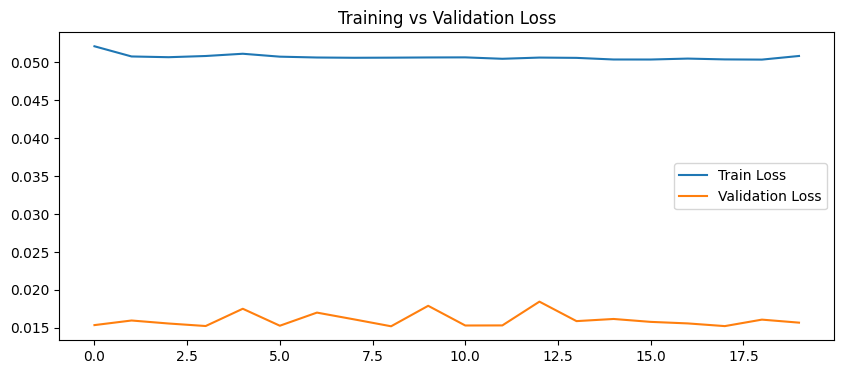

In [28]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [29]:
y_pred = model.predict(X_test).flatten()


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


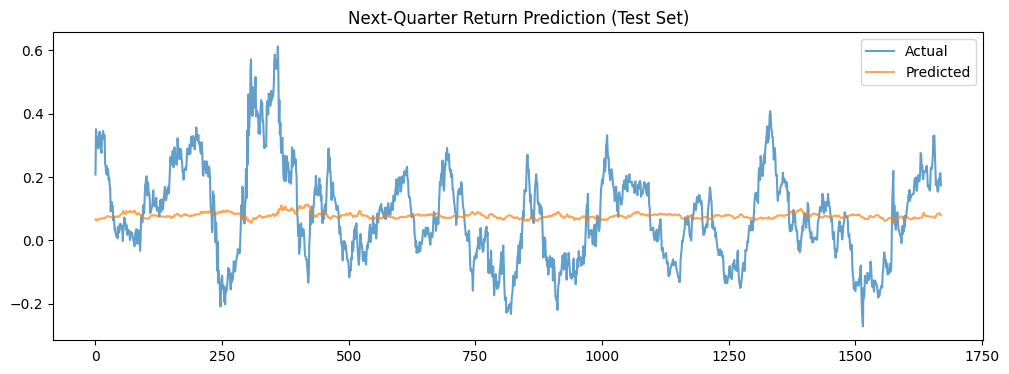

In [30]:
plt.figure(figsize=(12,4))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Next-Quarter Return Prediction (Test Set)")
plt.show()


In [32]:
len(y_test)

1670

In [33]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)


Test MSE: 0.021663945036730442
